[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building CMNDs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.6.4


Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

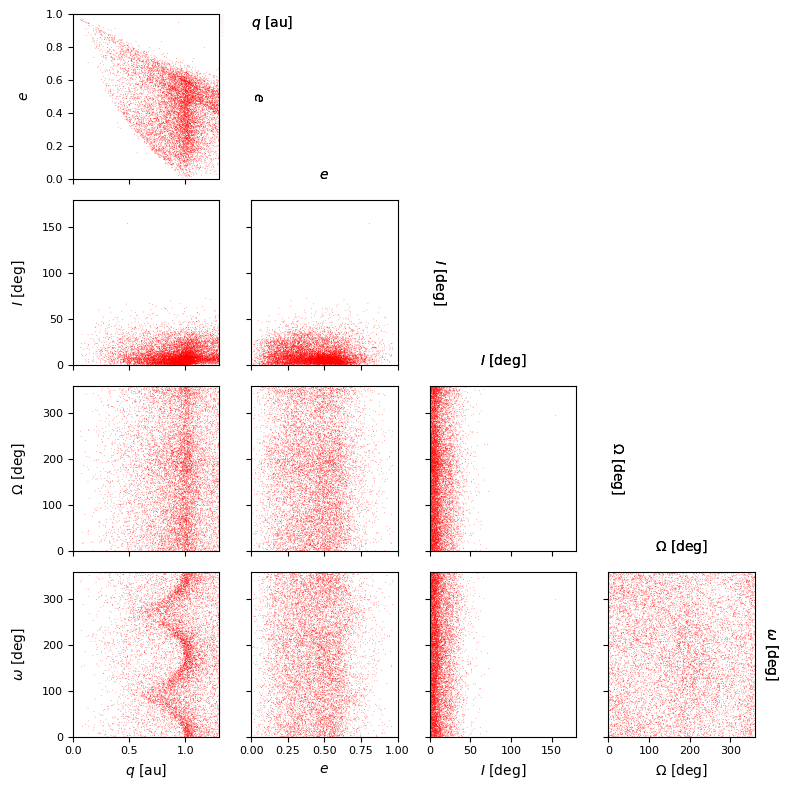

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.DensityPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

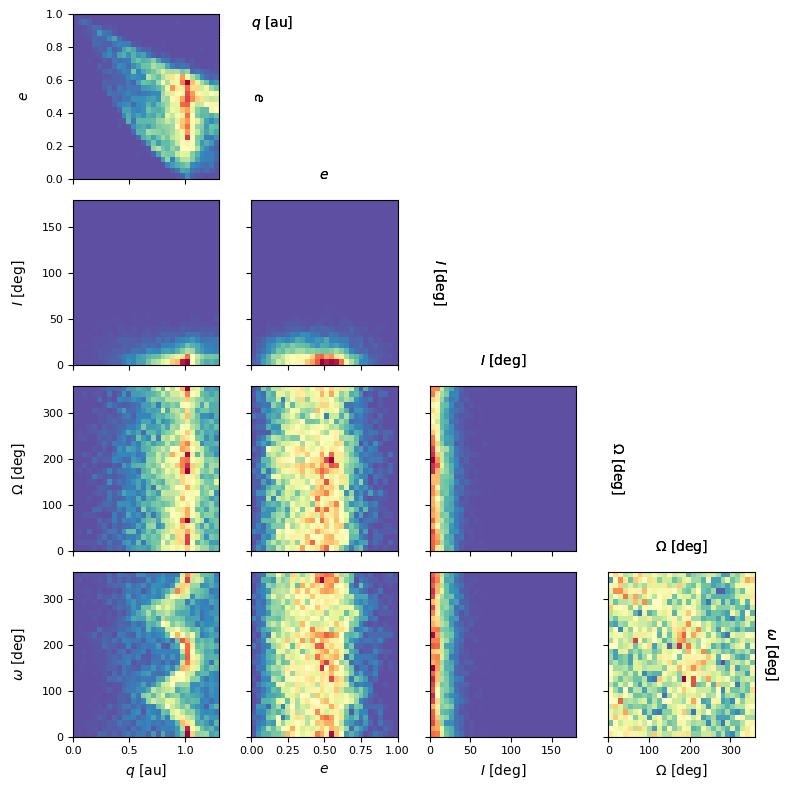

In [5]:
G=mn.DensityPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [207]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

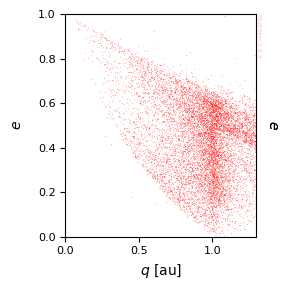

In [208]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')



Now we will proceed to fit the data against a singled truncated distribution:

In [251]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(data_neas_qe, advance=0)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 157.431 ms
-log(L)/N = -0.5533010253870283


And check the fit result:

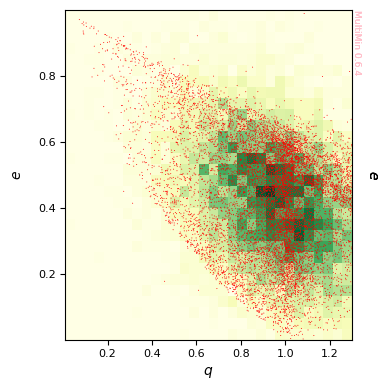

In [252]:
props=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qe_1.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [253]:
F_qe_1.cmnd.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.971819,0.414407,0.262553,0.186427,-0.416013


We can do it better increasing the number of normals:

In [254]:
t = mn.Util.el_time(0)
F = mn.FitCMND(ngauss=5, nvars=2, domain=[[0,1.3], [0, 1]])
F.fit_data(data_neas_qe, advance=True)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Iterations:
Iter 0:
	Vars: [-1.5, -1.3, -1.3, -1.3, -1.5, 0.49, 0.14, 0.82, 0.32, 0.96, 0.45, 1, 0.55, 1.2, 0.71, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, 0.71, 0.63, 0.71, 0.42, 1.1]
	LogL/N: 2.0307846301007713
Iter 1:
	Vars: [-1.6, -1.2, -1.2, -1.2, -1.6, 0.55, 0.058, 0.82, 0.33, 0.97, 0.43, 0.93, 0.54, 1.2, 0.7, -4.5, -4.8, -4.5, -4.7, -4.5, -4.7, -4.4, -4.7, -4.5, -4.7, -0.16, -0.44, -0.18, -1.1, 1]
	LogL/N: 0.44048706634264584
Iter 2:
	Vars: [-1.6, -1.2, -1.2, -1.2, -1.6, 0.6, 0.038, 0.8, 0.17, 1.1, 0.33, 0.81, 0.6, 1.3, 0.57, -4.5, -4.8, -4.4, -4.7, -4.5, -4.7, -4.3, -4.7, -4.5, -4.7, -0.19, -0.49, -0.22, -1.2, 1]
	LogL/N: 0.00909763620752585
Iter 3:
	Vars: [-1.6, -1.2, -1.2, -1.2, -1.7, 0.59, 0.049, 0.83, 0.25, 1.1, 0.32, 0.78, 0.56, 1.2, 0.55, -4.5, -4.8, -4.4, -4.7, -4.5, -4.7, -4.3, -4.7, -4.5, -4.7, -0.24, -0.55, -0.27, -1.3, 0.99]
	LogL/N: -0.14651015948907944
Iter 4:
	Vars: [-1.6, -1.2, -1.2, -1.2, -1.6, 0.59, 0.058, 0.84, 0.28, 1.1, 0.32, 0.79, 0.59, 1.

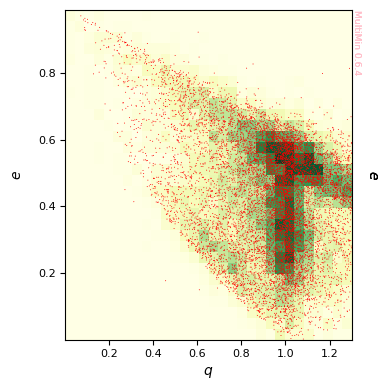

In [255]:
props=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [256]:
neas_sample = F.cmnd.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

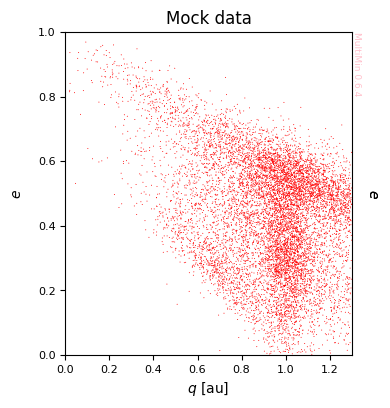

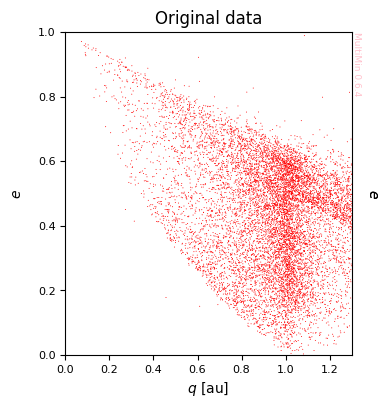

In [257]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.DensityPlot(properties,figsize=4)
G.scatter_plot(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.DensityPlot(properties,figsize=4)
scatter=G.scatter_plot(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [258]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.cmnd.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
2,0.345275,0.924051,0.372524,0.261426,0.162754,-0.675062
4,0.256545,1.274792,0.455275,0.476196,0.190635,-0.966508
3,0.201057,1.004990,0.318524,0.057173,0.143617,-0.108733
5,0.111983,1.015324,0.545004,0.137288,0.060919,0.046054
1,0.085140,0.731402,0.235852,0.164142,0.118797,-0.921639


In [259]:
function, cmnd = F.cmnd.get_function(properties=properties)

import numpy as np
from multimin import tnmd

def cmnd(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.731402
    mu1_e = 0.235852
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.026942, -0.017972], [-0.017972, 0.014113]]
    Z1 = 0.976442
    n1 = tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.924051
    mu2_e = 0.372524
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.068343, -0.028723], [-0.028723, 0.026489]]
    Z2 = 0.920885
    n2 = tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 1.00499
    mu3_e = 0.318524
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.003269, -0.000893], [-0.000893, 0.020626]]
    Z3 = 0.986717
    n3 = tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.274792
    mu4_e = 0.455275
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.226763, -0.087739], [-0.087739, 0.036342]]
    Z4 = 0.517083
    n4 = tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.015324
    mu5_e = 0.545004
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.018848, 0.000385], [0.000385, 0.003711]]
    Z5 = 0.980941
    n5 

### Fitting other pair of properties

Fitting $q$ and $I$:

-log(L)/N = 3.47160195670066


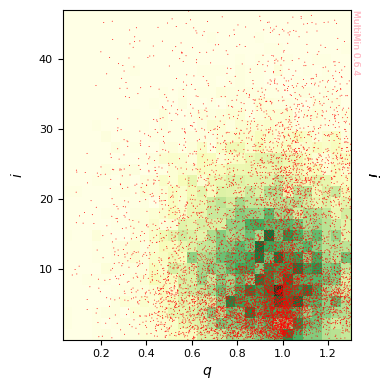

In [263]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(data_neas_qi, advance=0)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

props=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qi_1.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

-log(L)/N = 3.300170089941388


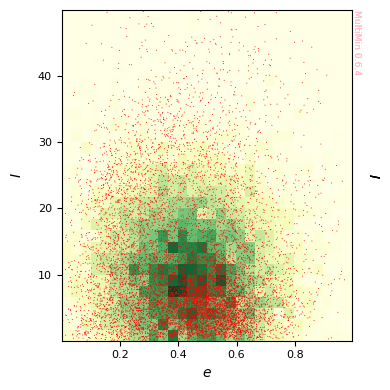

In [262]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(data_neas_ei, advance=0)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

props=["e","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [264]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

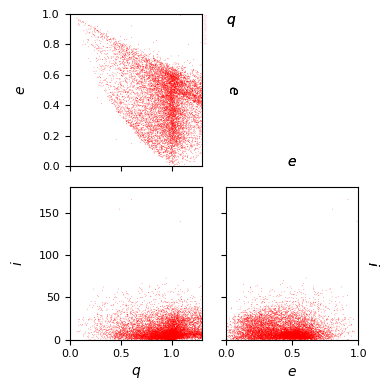

In [265]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.DensityPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.scatter_plot(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Iterations:
Iter 0:
	Vars: [0.38, 0.5, 0.0028, -2.5, -2.2, -7.5, 1.4, 0.88, 0.17]
	LogL/N: 689.8344061886103
Iter 1:
	Vars: [0.39, 0.49, 0.063, -2.5, -2.2, -7.5, 1.3, 0.93, 0.41]
	LogL/N: 688.9846668879474
Iter 2:
	Vars: [0.39, 0.49, 0.063, -2.5, -2.2, -7.5, 1.3, 0.93, 0.41]
	LogL/N: 688.9846668653578
Iter 3:
	Vars: [0.39, 0.49, 0.063, -2.5, -2.2, -7.5, 1.3, 0.93, 0.41]
	LogL/N: 688.9846668649998
-log(L)/N = 56.187380473998886


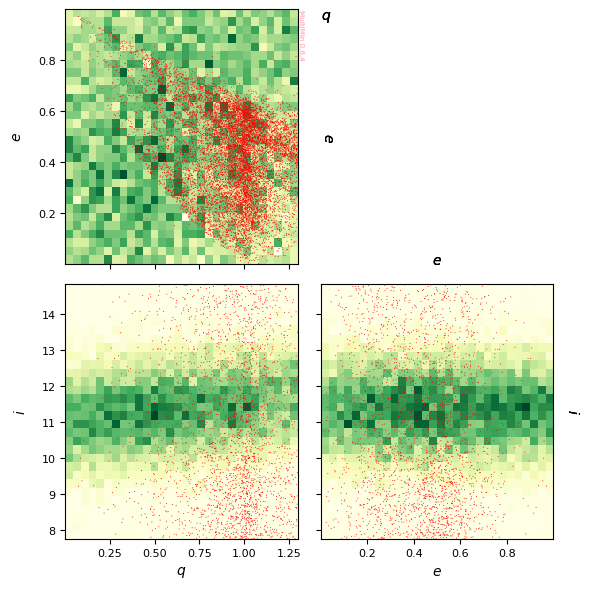

In [272]:
fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

props=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

Iterations:
Iter 0:
	Vars: [0.75, 0.42, 0.047, -3.9, -4, -5.2, -0.89, -0.039, -0.087]
	LogL/N: 672.9120312911214
Iter 1:
	Vars: [0.75, 0.42, 0.047, -3.9, -4, -5.2, -0.89, -0.039, -0.087]
	LogL/N: 672.9120312508351
Iter 2:
	Vars: [0.75, 0.42, 0.047, -3.9, -4, -5.2, -0.89, -0.039, -0.087]
	LogL/N: 672.9120310769173
-log(L)/N = -2.3792578205740207


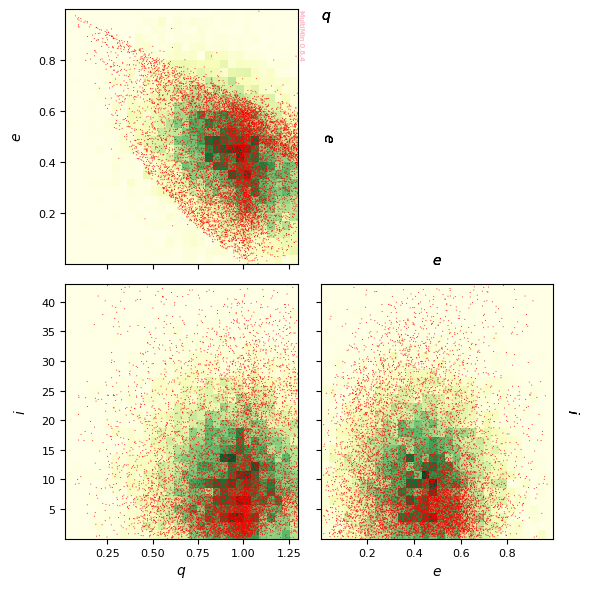

In [273]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.cmnd.mus[0, 0] + F_qi_1.cmnd.mus[0, 0]) / 2
mu_e = (F_qe_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 0]) / 2
mu_i = (F_qi_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 1]) / 2
sigma_q = (F_qe_1.cmnd.sigmas[0, 0] + F_qi_1.cmnd.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.cmnd.rhos[0, 0])
rho_qi = float(F_qi_1.cmnd.rhos[0, 0])
rho_ei = float(F_ei_1.cmnd.rhos[0, 0])

fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

props=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Iterations:
Iter 0:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.97, 0.42, 8.4, 0.97, 0.42, 8.4, 0.97, 0.42, 8.4, 0.97, 0.42, 8.4, 0.97, 0.42, 8.4, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.89, -0.039, -0.087, -0.89, -0.039, -0.087, -0.89, -0.039, -0.087, -0.89, -0.039, -0.087, -0.89, -0.039, -0.087]
	LogL/N: 3.0760640975177886


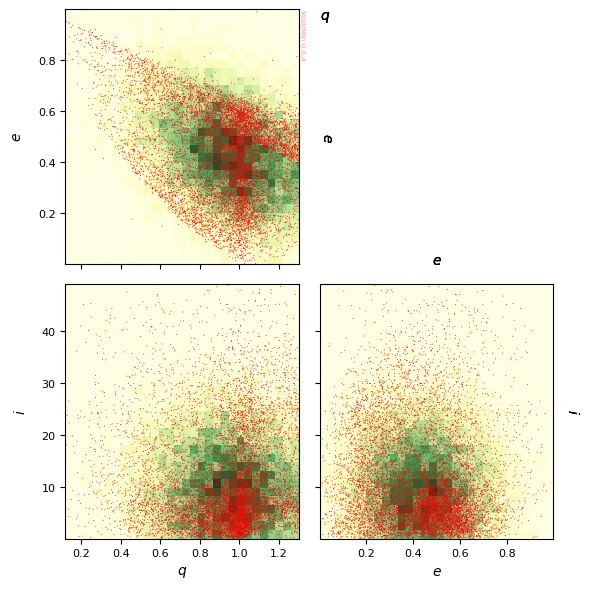

In [276]:
fit_qei = mn.FitCMND(ngauss=5, nvars=3, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(data_neas_qei, advance=True)
G=fit_qei.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the CMND is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the CMND in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [148]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

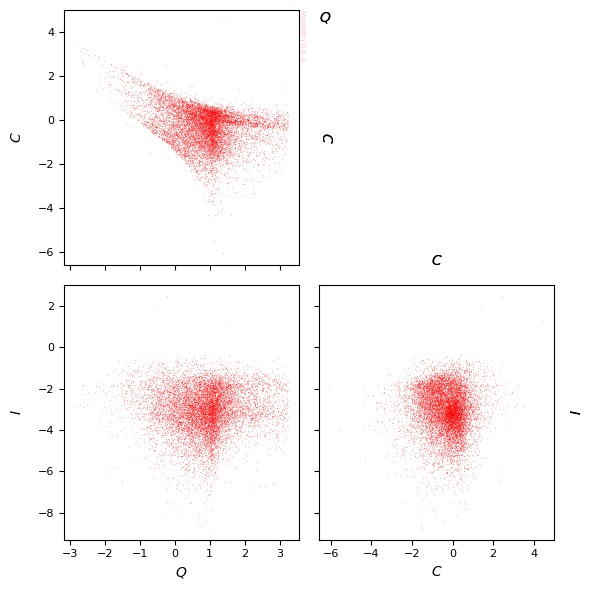

In [149]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

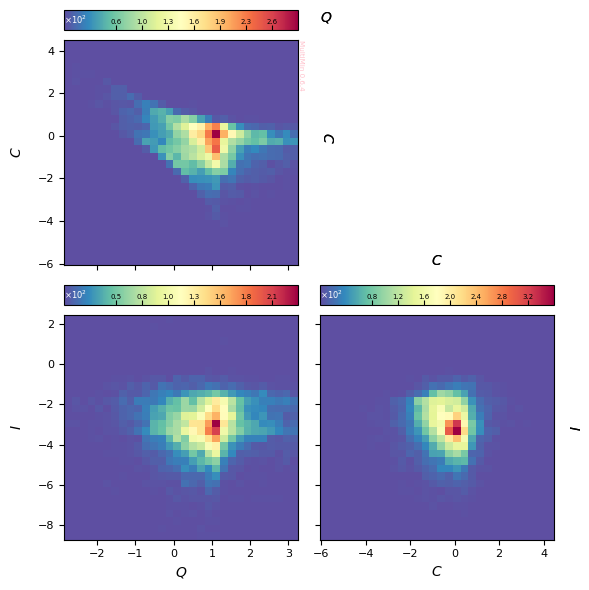

In [150]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [163]:
F=mn.FitCMND(ngauss=1,nvars=3)

The fitter holds an initial CMND that will be optimized:

In [164]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.0, 0.0, 0.0]]
    Standard deviations (σ): [[1.0, 1.0, 1.0]]
    Correlation coefficients (ρ): [[0.0, 0.0, 0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


Run the minimization:

In [165]:
t = mn.Util.el_time(0)
F.fit_data(udata,verbose=False,advance=1)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Iterations:
Iter 0:
	Vars: [2.3, 1.4, -2, -1.9, -1.7, -1.8, 1.4, 1.1, 1.1]
	LogL/N: 5.2670090072453055
Iter 1:
	Vars: [1.8, 0.53, -2.5, -1.8, -1.8, -1.9, 1.1, 1, 0.83]
	LogL/N: 4.730681165136137
Iter 2:
	Vars: [0.82, -0.38, -3.1, -2.2, -2.2, -2, -0.026, 0.25, 0.53]
	LogL/N: 4.101027072255319
Iter 3:
	Vars: [0.88, -0.35, -3, -2.4, -2.4, -2.1, -0.61, 0.057, -0.05]
	LogL/N: 3.957667228715345
Iter 4:
	Vars: [0.87, -0.34, -3.1, -2.4, -2.4, -2.1, -0.63, 0.07, -0.11]
	LogL/N: 3.9566023805460455
Iter 5:
	Vars: [0.87, -0.33, -3.1, -2.4, -2.4, -2.1, -0.63, 0.07, -0.11]
	LogL/N: 3.956409860378012
Iter 6:
	Vars: [0.87, -0.33, -3.1, -2.4, -2.4, -2.1, -0.63, 0.07, -0.11]
	LogL/N: 3.956409860378012
Elapsed time since last call: 174.662 ms
-log(L)/N = 3.956409860378012


Inspect the fitted CMND:

In [166]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8669809967085199, -0.33033288260821564, -3.0632032124443644]]
    Standard deviations (σ): [[0.8471326578176342, 0.8584841817072988, 1.0724779339656703]]
    Correlation coefficients (ρ): [[-0.30690098457241366, 0.0350841032990763, -0.0544600588696581]]

    Covariant matrices (Σ): 
        [[[0.717633739941169, -0.22319373690065916, 0.03187499835415294], [-0.22319373690065916, 0.7369950902416504, -0.05014166710185816], [0.03187499835415294, -0.05014166710185816, 1.1502089188432725]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8669809967085199, -0.33033288260821564, -3.0632032124443644, 0.717633739941169, -0.22319373690065916, 0.03187499835415294, 0.7369950902416504, -0.05014166710185816, 1.1502089188432725]
        With std. and corre

Plot the fit result (fitted sample + data scatter):

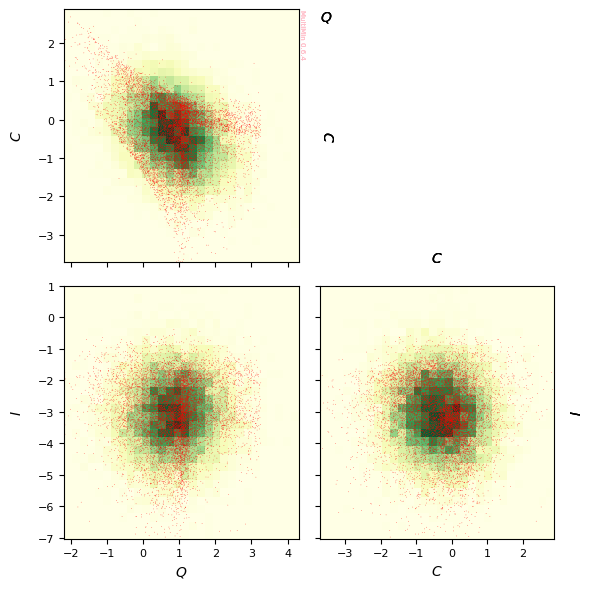

In [167]:
props=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [168]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [169]:
F=mn.FitCMND(f"gallery/{figprefix}_fit-single.pkl")
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8669809967085199, -0.33033288260821564, -3.0632032124443644]]
    Standard deviations (σ): [[0.8471326578176342, 0.8584841817072988, 1.0724779339656703]]
    Correlation coefficients (ρ): [[-0.30690098457241366, 0.0350841032990763, -0.0544600588696581]]

    Covariant matrices (Σ): 
        [[[0.717633739941169, -0.22319373690065916, 0.03187499835415294], [-0.22319373690065916, 0.7369950902416504, -0.05014166710185816], [0.03187499835415294, -0.05014166710185816, 1.1502089188432725]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8669809967085199, -0.33033288260821564, -3.0632032124443644, 0.717633739941169, -0.22319373690065916, 0.03187499835415294, 0.7369950902416504, -0.05014166710185816, 1.1502089188432725]
        With std. and corre

Fit with two Gaussian components for a better likelihood:

Iterations:
Iter 0:
	Vars: [0, 0, 2.7, 1.4, -2.1, 1.8, 0.5, -2.3, -1.3, -1.4, -1.6, -2.1, -2.1, -2, 1.5, 1.2, 1.2, 1.3, 1.3, 0.87]
	LogL/N: 4.933655513767609
Iter 5:
	Vars: [-1.5, -0.023, 0.25, 0.32, -3.4, 1.1, -0.56, -2.9, -2.4, -2.6, -1.9, -2.5, -2.5, -2.3, -1.5, -0.7, 0.54, 0.075, 0.23, -0.13]
	LogL/N: 3.8809556667807272
Iter 10:
	Vars: [-1.5, -0.024, 0.48, 0.45, -3.4, 0.99, -0.6, -2.9, -2.4, -2.8, -2, -2.4, -2.5, -2.2, -2.3, -0.66, 0.62, -0.068, 0.21, 0.006]
	LogL/N: 3.87412138386316
Iter 11:
	Vars: [-1.5, -0.024, 0.48, 0.45, -3.4, 0.99, -0.6, -2.9, -2.4, -2.8, -2, -2.4, -2.5, -2.2, -2.3, -0.66, 0.62, -0.068, 0.21, 0.006]
	LogL/N: 3.87412138386316
Elapsed time since last call: 1.08232 s
-log(L)/N = 3.87412138386316
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.2633195722146473, 0.7366804277853527]
    Number of variables: 3
    Averages (μ): [[0.47684689391453916, 0.4532408474178258, -3.432709778133324], [0.9915957825617516, -0.5960

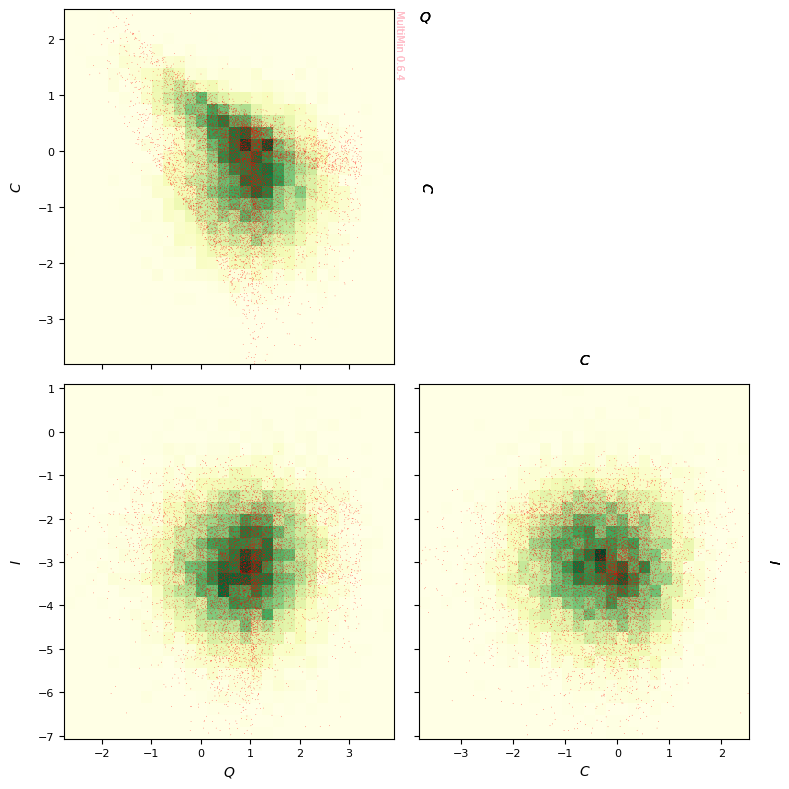

In [175]:
F=mn.FitCMND(ngauss=2,nvars=3)

mn.Util.el_time(0)
F.fit_data(udata,advance=5)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)

G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.7, 1.4, -2.1, 1.8, 0.49, -2.3, -1.3, -1.4, -1.6, -2.1, -2.1, -2, 1.5, 1.2, 1.2, 1.3, 1.3, 0.86]
	LogL/N: 4.934451225597257
Iter 5:
	Vars: [-0.67, 2.2, 0.25, 0.32, -3.4, 1.1, -0.56, -2.9, -2.4, -2.6, -1.9, -2.5, -2.5, -2.3, -1.5, -0.7, 0.54, 0.073, 0.23, -0.13]
	LogL/N: 3.880971528403555
Iter 10:
	Vars: [-0.75, 2.2, 0.48, 0.45, -3.4, 0.99, -0.6, -2.9, -2.4, -2.8, -2, -2.4, -2.5, -2.2, -2.3, -0.66, 0.62, -0.068, 0.21, 0.0055]
	LogL/N: 3.8741203173935435
Iter 11:
	Vars: [-0.75, 2.2, 0.48, 0.45, -3.4, 0.99, -0.6, -2.9, -2.4, -2.8, -2, -2.4, -2.5, -2.2, -2.3, -0.66, 0.62, -0.068, 0.21, 0.0055]
	LogL/N: 3.8741203173935435
Elapsed time since last call: 1.16254 s
-log(L)/N = 3.8741203173935435
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.26308428061729455, 0.7369157193827056]
    Number of variables: 3
    Averages (μ): [[0.4763203687003152, 0.45364411926953896, -3.4321820405954506], [0.9915829413262264,

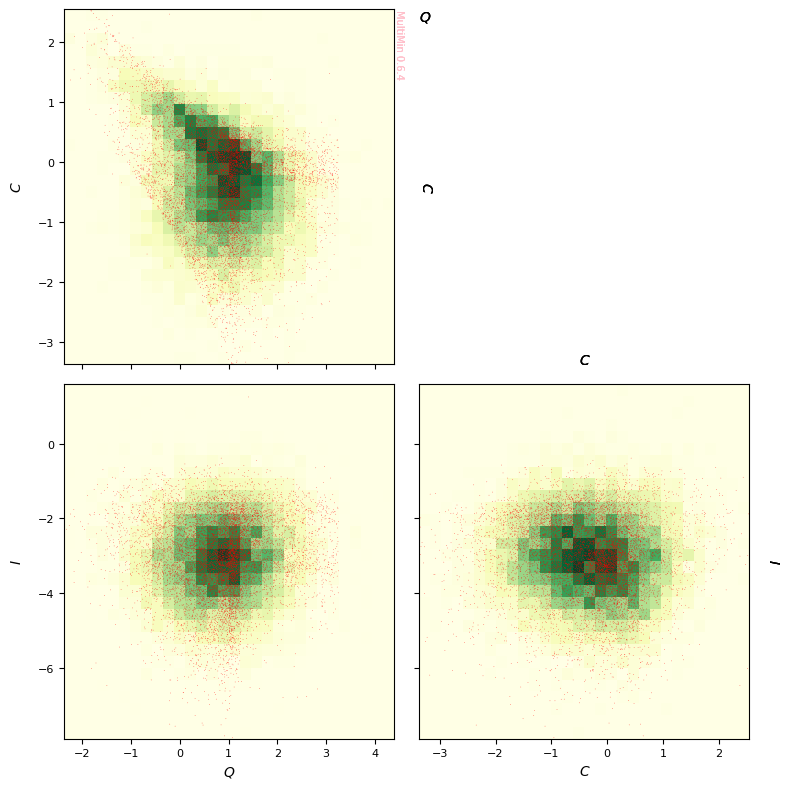

In [176]:
F=mn.FitCMND(ngauss=2,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=5,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.2, 2.2, 2.2, 2.9, 1.5, -2.2, 2.7, -0.02, -2.2, 1.9, 0.32, -2.9, 1.7, 0.33, -2.2, 0.33, 2, -2.1, -1.3, -1.2, -1.3, -1.4, -2.2, -2.4, -2.1, -3.1, -2, -2.3, -1.9, -2.1, -2.3, -1.3, -2, 2.3, 1.8, 1.3, 2.2, 1.3, 0.8, 0.46, 1.4, 1.1, 1.5, 1.4, 1.1, 0.6, 0.49, 1.1]
	LogL/N: 4.715308108189624
Iter 10:
	Vars: [-2.2, 2, 1.4, -0.59, 0.067, 2, -1.5, -3.5, 0.89, -0.72, -2.6, 1.2, 0.2, -3.3, 1.1, -0.49, -3.8, -0.22, -0.065, -2.8, -2.3, -2, -1.5, -3.1, -2.5, -2.5, -2.4, -3.4, -2.3, -3, -2.9, -1.9, -2.7, -2.1, -2.2, 1.1, 1.8, 0.11, -0.55, 0.5, -0.04, -1.7, 0.55, -0.14, -0.65, 1.6, -0.72, -1.9, -0.23, 0.35]
	LogL/N: 3.732809777325343
Iter 20:
	Vars: [-1.8, -0.3, 0.5, 0.66, 0.49, 1.8, -0.46, -3.9, 1, -0.83, -2, 1.2, 0.24, -3.1, 0.97, -0.35, -3.4, 0.065, -0.47, -3.1, -2.3, -2.8, -1.7, -2.5, -2.5, -2.9, -2.4, -3.3, -2.5, -3.4, -2.8, -2.2, -2.6, -2, -2.1, 0.48, 1.7, 0.23, -0.79, 0.14, 0.74, -2, 0.24, 0.11, -0.84, 0.53, -0.86, -2.2, -0.4, 0.37]
	LogL/N: 3.706726986404

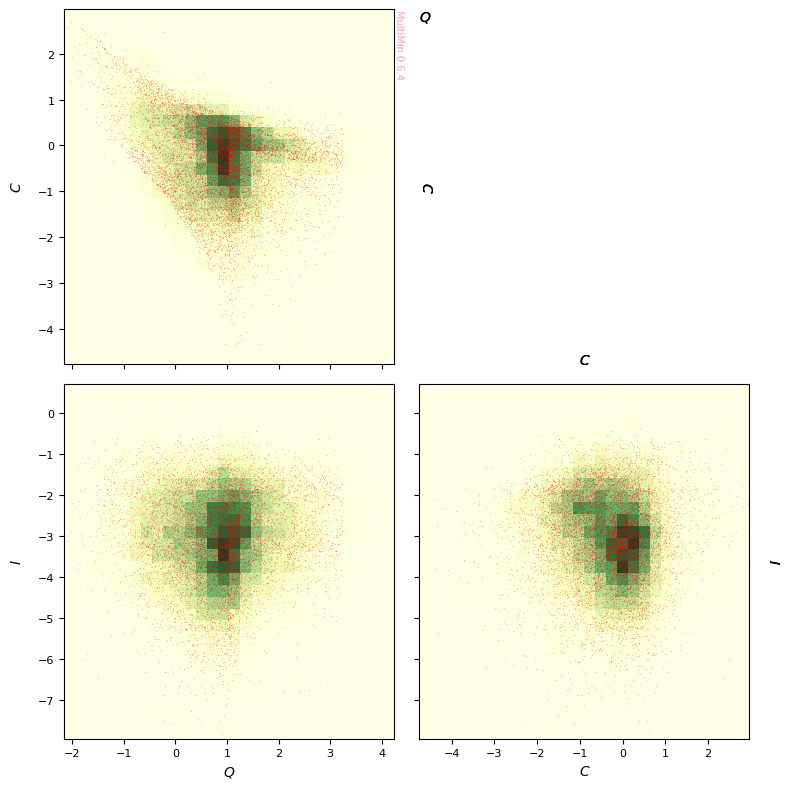

In [172]:
F=mn.FitCMND(ngauss=5,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=10,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted CMND and comparing to the data:

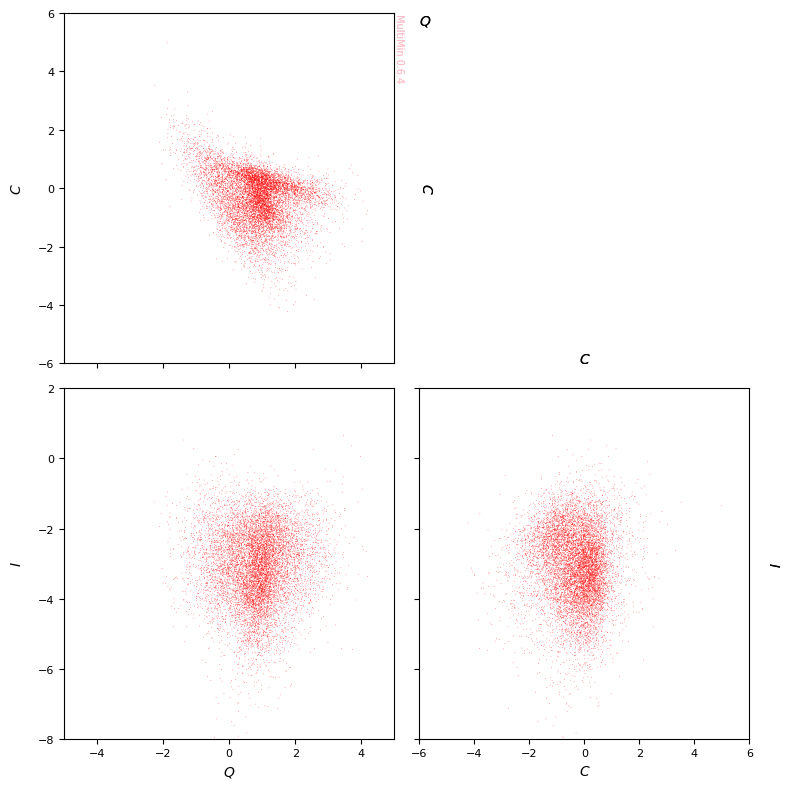

In [173]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=4,
                  props=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample-multiple-{F.prefix}.png")

Compare with the original data distribution:

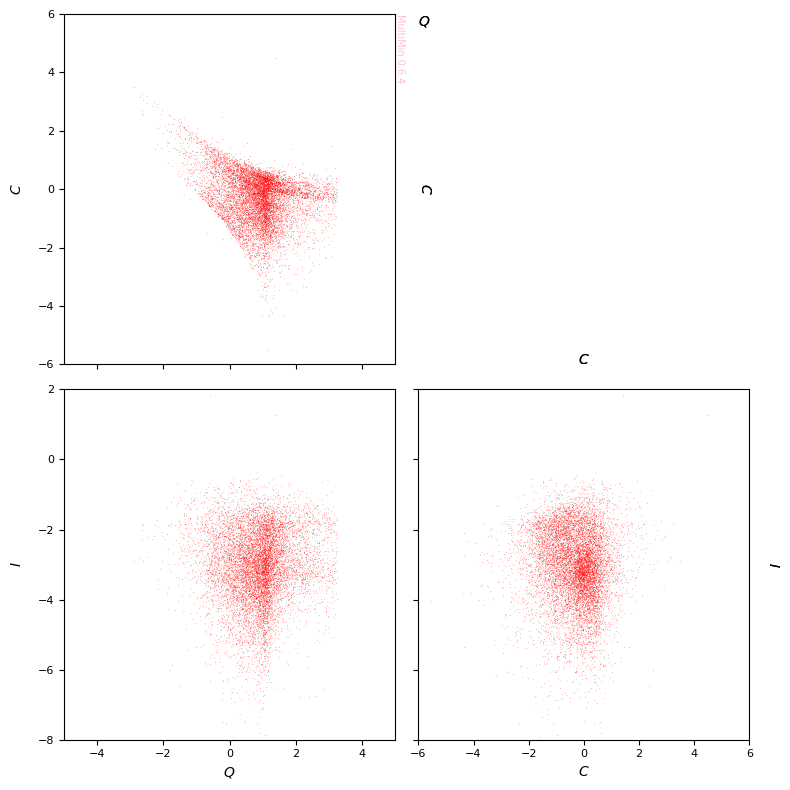

In [174]:
properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=4)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)
G.fig.savefig(f"gallery/{figprefix}_true_MPC_sample_QCI.png")

Fitting with 20 components can approximate the distribution very closely:

Iterations:
Iter 0:
	Vars: [2.2, 2.1, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 3.1, 1.6, -2.3, 2.9, -0.094, -2.3, 2.4, -0.18, -2.8, 2.4, -0.3, -2.3, 2.2, -0.32, -3.6, 2.2, -0.31, -2.2, 2, -0.27, -2.8, 2, -0.33, -2.6, 1.9, 3, -2, 1.9, -0.26, -4.1, 1.8, -0.13, -2.3, 1.8, -0.16, -2.5, 1.7, 3, -1.7, 1.6, 0.4, -3.1, 1.6, 0.73, -2.7, 1.5, 0.77, -2.5, 1.4, 2.5, -1.5, 1.3, 0.84, -4.1, 1, 1.5, -1.7, 0.95, 0.87, -1.7, -0.43, -1, -2.5, -1.1, -3.6, -2.3, -1.5, -3.5, -2.6, -1.6, -1.8, -2.7, -1.8, -3.2, -2.9, -1.8, -2.1, -2.8, -2, -2.6, -1.5, -2.1, -2.2, -2.3, -1, -0.51, -1.8, -2.1, -3, -2.2, -2.2, -2.1, -2.4, -2.4, -2.2, -2.2, -1.2, -0.56, -3.6, -2.4, -3.9, -2.4, -2, -3.1, -2.3, -2.3, -1.6, -2, -1.4, -0.89, -2.8, -2.2, -2.8, -2.1, -1.9, -1.6, -1.9, -2.3, -1.9, -2.3, 2.6, 2.3, 1, 0.84, 1.3, -0.49, -0.58, 0.92, -1.4, 2.7, 1.6, 0.79, 0.9, 0.23, -0.74, 1.9, 1, 0.23, 1.5, 1.4, 0.88, 1.2, 1.3, 0.53, 1.5, 1.6, 1.9, 0.77, 0.35, 0.34, 1.6, 1, 0.74, 1.5, 1.1, 

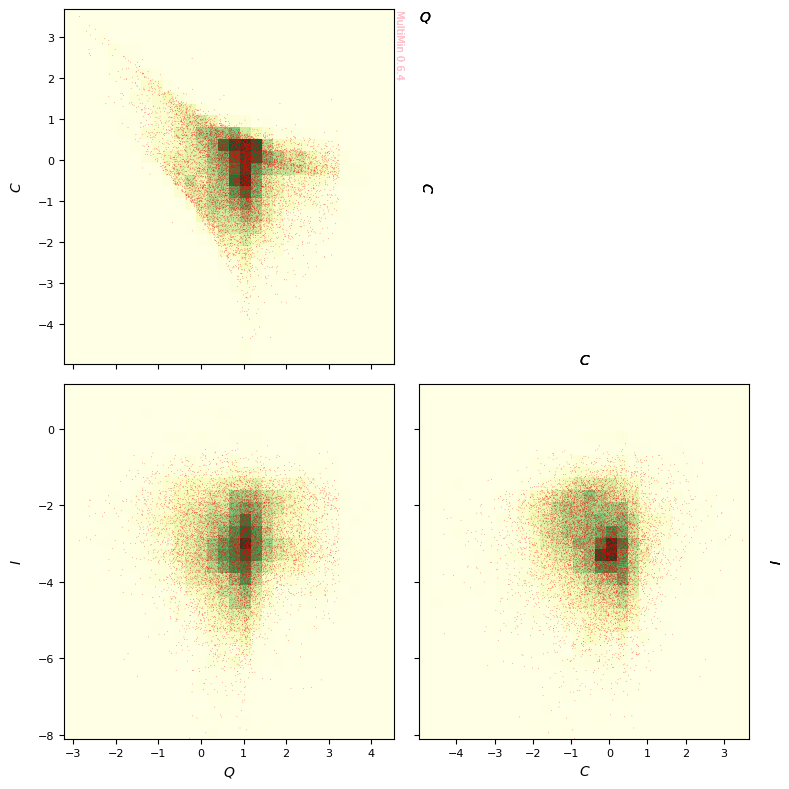

In [177]:
F=mn.FitCMND(ngauss=20,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=10,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bound_mus.pkl",useprefix=True)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_indepth_fit_20gauss_bound_mus_QCI.png")

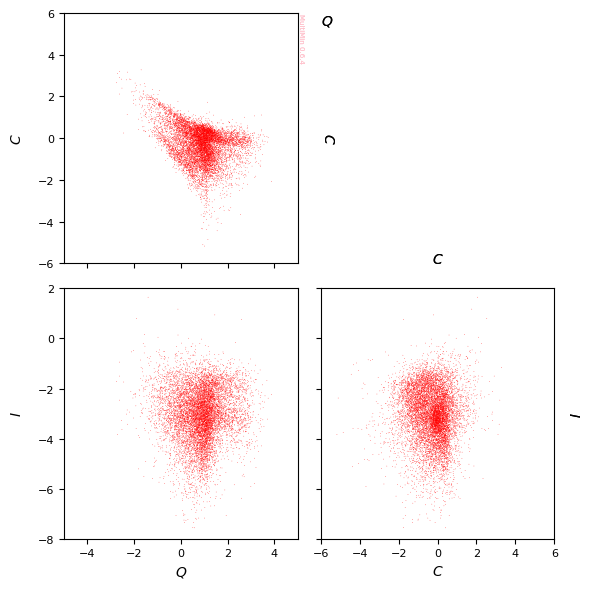

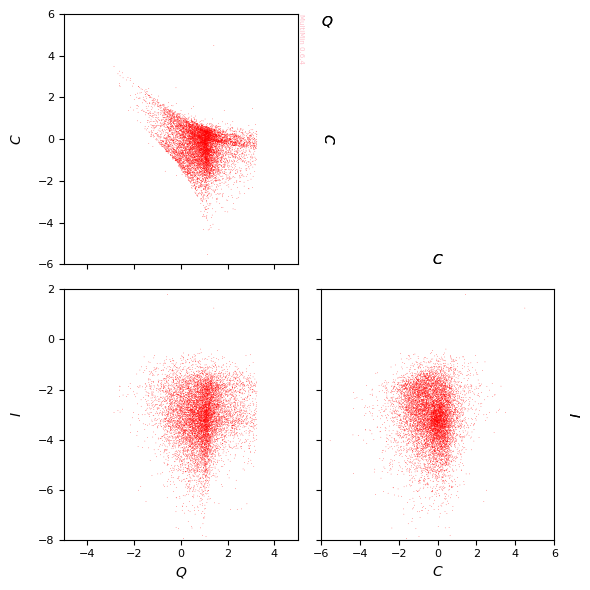

In [181]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=3,
                  props=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")
properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

In [184]:
function, cmnd = F.cmnd.get_function(properties=properties)

from multimin import nmd

def cmnd(X):

    mu1_Q = -0.563051
    mu1_C = 1.376317
    mu1_I = -3.149978
    mu1 = [mu1_Q, mu1_C, mu1_I]
    Sigma1 = [[0.227753, -0.181985, -0.243206], [-0.181985, 0.15576, 0.216788], [-0.243206, 0.216788, 1.603135]]
    n1 = nmd(X, mu1, Sigma1)

    mu2_Q = 2.353099
    mu2_C = 0.025113
    mu2_I = -2.981893
    mu2 = [mu2_Q, mu2_C, mu2_I]
    Sigma2 = [[0.246671, -0.042363, -0.037632], [-0.042363, 0.062482, 0.06641], [-0.037632, 0.06641, 0.816864]]
    n2 = nmd(X, mu2, Sigma2)

    mu3_Q = 1.949954
    mu3_C = -0.137068
    mu3_I = -1.768245
    mu3 = [mu3_Q, mu3_C, mu3_I]
    Sigma3 = [[0.465464, -0.083037, -0.028306], [-0.083037, 0.225013, -0.120821], [-0.028306, -0.120821, 0.156655]]
    n3 = nmd(X, mu3, Sigma3)

    mu4_Q = 0.525176
    mu4_C = -0.401491
    mu4_I = -4.14377
    mu4 = [mu4_Q, mu4_C, mu4_I]
    Sigma4 = [[0.124111, -0.047426, -0.01637], [-0.047426, 0.383768, 0.307362], [-0.01637, 0.307362, 1.979219]]
    n4 = nmd(X, mu4, Sigma4)

 

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga